# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics 

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In the previous assignment you pulled lyrics data on two artists. In this assignment we explore this data set and a pull from the now-defunct Twitter API for the artists Cher and Robyn.  If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Canvas. 

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mammajamma/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

sw = stopwords.words("english")

In [21]:
# change `data_location` to the location of the folder on your machine.
#data_location = "/users/chandler/dropbox/teaching/repos/ads-tm-api-scrape/"
data_location = "/Users/mammajamma/Projects/ADS509assgn2/M1 Results/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

In [29]:
from collections import Counter

def descriptive_stats(tokens, num_tokens=5, verbose=True):
    """
    Given a list of tokens, 
    - print number of tokens
    - number of unique tokens
    - number of characters
    - lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity)
    - and num_tokens most common tokens.
    
    Return a list with the number of tokens, number of unique tokens, 
    lexical diversity, and number of characters. 
    """
    # Fill in the correct values here\
    #tokens
    num_tokens_total = len(tokens)
    #unique tokens                        
    num_unique_tokens = len(set(tokens)) 
    #num of characters                  
    num_characters = sum(len(t) for t in tokens)           
    lexical_diversity = (num_unique_tokens / num_tokens_total 
                         if num_tokens_total > 0 else 0)   # avoid division by 0
    
    if verbose:        
        print(f"There are {num_tokens_total} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the most common tokens
        common = Counter(tokens).most_common(num_tokens)
        print(f"\nTop {num_tokens} tokens:")
        for token, count in common:
            print(f"{token}: {count}")
    
    return [num_tokens_total, num_unique_tokens, lexical_diversity, num_characters]


In [30]:
text = """here is some example text with other example text here in this text""".split()
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)


There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.

Top 5 tokens:
text: 3
here: 2
example: 2
is: 1
some: 1


Q: Why is it beneficial to use assertion statements in your code? 

A: Assertion statements make sure you are on the right track with your code.  If you are counting words for example and you run a chunk of code, an assertion statement can help to make sure the code that you ran is true.  If you are trying to count the number of sentences in a text file, how do you know the returned number is true?  The code you ran could have been incorrect or had an error and if you just take it blindly, you don't know if the mistake is made and you could continue with your code with false information.  An assertion statement in this example would be checking to see maybe what the first sentence is based on your return and the last, this way you can be sure all sentences are accounted for.  Essentially like a version of unit testing kind of, it makes sure that your code is not buggy. 

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [31]:
# Read in the lyrics data
lyrics_data = {}

artists_path = os.path.join(data_location, lyrics_folder)

for artist in os.listdir(artists_path):
    artist_folder = os.path.join(artists_path, artist)

    if os.path.isdir(artist_folder):
        lyrics_data[artist] = {}

        for file in os.listdir(artist_folder):
            if file.endswith(".txt"):
                song_name = file.replace(".txt", "").replace(f"{artist}_", "")

                with open(os.path.join(artist_folder, file), "r") as f:
                    lyrics_data[artist][song_name] = f.read()

In [32]:
twitter_data = {}

twitter_path = os.path.join(data_location, twitter_folder)

for file in os.listdir(twitter_path):
    if file.endswith("_followers_data.txt"):                 
        artist = file.replace("_followers_data.txt", "")
        descriptions = []

        with open(os.path.join(twitter_path, file), "r") as f:
            header = f.readline().strip().split("\t")        
            if "description" in header:                      
                desc_index = header.index("description")
                for line in f:
                    parts = line.strip().split("\t")
                    if len(parts) > desc_index:              
                        descriptions.append(parts[desc_index])

        twitter_data[artist] = descriptions

## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame. 



In [33]:
punctuation = set(punctuation) # speeds up comparison

In [34]:
# create your clean twitter data here

clean_twitter_data = {}

for artist, description in twitter_data.items():
    tokens = []

    for desc in descriptions: 
        words = desc.lower().split()
        words = [w.strip("".join(punctuation)) for w in words]
        words = [w for w in words if w not in sw and w != ""]
        tokens.extend(words)
    clean_twitter_data[artist] = tokens

In [35]:
# create your clean lyrics data here
clean_lyrics_data = {}

for artist, songs in lyrics_data.items():
    tokens = []
    for song, text in songs.items():
        words = text.lower().split()  # lowercase + split
        words = [w.strip("".join(punctuation)) for w in words]
        words = [w for w in words if w not in sw and w != ""]
        tokens.extend(words)
    clean_lyrics_data[artist] = tokens

## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls). 

In [38]:
# calls to descriptive_stats here

# Twitter
print("Twitter - Cher")
descriptive_stats(clean_twitter_data["cher"])

print("\nTwitter - Robyn")
descriptive_stats(clean_twitter_data["robynkonichiwa"])

# Lyrics
print("\nLyrics - Cher")
descriptive_stats(clean_lyrics_data["cher"])

print("\nLyrics - Robyn")
descriptive_stats(clean_lyrics_data["robyn"])


Twitter - Cher
There are 1482635 tokens in the data.
There are 257718 unique tokens in the data.
There are 9258438 characters in the data.
The lexical diversity is 0.174 in the data.

Top 5 tokens:
music: 15146
love: 11663
och: 7922
life: 7381
de: 6382

Twitter - Robyn
There are 1482635 tokens in the data.
There are 257718 unique tokens in the data.
There are 9258438 characters in the data.
The lexical diversity is 0.174 in the data.

Top 5 tokens:
music: 15146
love: 11663
och: 7922
life: 7381
de: 6382

Lyrics - Cher
There are 33467 tokens in the data.
There are 3712 unique tokens in the data.
There are 164699 characters in the data.
The lexical diversity is 0.111 in the data.

Top 5 tokens:
love: 1004
know: 486
time: 319
baby: 319
see: 308

Lyrics - Robyn
There are 14127 tokens in the data.
There are 2141 unique tokens in the data.
There are 70442 characters in the data.
The lexical diversity is 0.152 in the data.

Top 5 tokens:
know: 308
love: 275
got: 251
like: 232
baby: 222


[14127, 2141, 0.1515537622991435, 70442]

Q: How do you think the "top 5 words" would be different if we left stopwords in the data? 

A: They would probably all be stop words because they would appear most frequently. 

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs? 

A: I honestly don't know much about either of these artists except that Cher I know to be mainstream.  I expect for mainstream pop singers like this that they use more generic verbiage a lot of love, babe, kiss type words so I would expect a low lexical diversity since I would have pressumed the same words were used often and there would not be as much diversity but it looks like they are both about the same, so I assume now with the data that we have that Robyn is also a more mainstream, similar type of artist as Cher.



## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist. 
1. For each artist, a histogram of song lengths (in terms of number of tokens) 

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.


In [39]:
assert(emoji.is_emoji("❤️"))
assert(not emoji.is_emoji(":-)"))

### Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions? 


In [48]:
# Your code here
for artist, descriptions in clean_twitter_data.items():
    all_tokens = [token for desc in descriptions for token in desc]  # flatten
    emojis = [t for t in all_tokens if emoji.is_emoji(t)]            # keep only emojis
    
    counts = Counter(emojis).most_common(10)                         # top 10
    print(f"Top 10 emojis for {artist}:")
    for e, c in counts:
        print(e, ":", c)


Top 10 emojis for cher:
❤ : 4783
🌈 : 4685
🏳 : 3528
♥ : 3103
✨ : 2223
🏻 : 1495
✌ : 1189
🏼 : 1139
♀ : 836
💙 : 809
Top 10 emojis for robynkonichiwa:
❤ : 4783
🌈 : 4685
🏳 : 3528
♥ : 3103
✨ : 2223
🏻 : 1495
✌ : 1189
🏼 : 1139
♀ : 836
💙 : 809


### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions? 


In [52]:
#your code
for artist, descriptions in twitter_data.items():

    all_tokens = [word for desc in descriptions for word in desc.split()]
    
    hashtags = [token for token in all_tokens if token.startswith("#")]
    
    counts = Counter(hashtags).most_common(10)

    print(f"Top 10 hashtags for {artist}:")
    if counts:
        for h, c in counts:
            print(h, ":", c)
    else:
        print("No hashtags found")
    print()



Top 10 hashtags for cher:
#BLM : 7919
#Resist : 5007
#BlackLivesMatter : 4226
#resist : 3133
#FBR : 2767
#blacklivesmatter : 2464
#TheResistance : 2459
#1 : 2226
# : 1965
#Resistance : 1518

Top 10 hashtags for robynkonichiwa:
#BlackLivesMatter : 311
#BLM : 273
#blacklivesmatter : 200
#1 : 187
#music : 150
# : 150
#Music : 93
#EDM : 79
#blm : 51
#TeamFollowBack : 51



### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [60]:
# Your code here
#need to keep punctuation as a string for this block:
from string import punctuation

punct_set = set(punctuation)

punct_string = punctuation


for artist, songs in lyrics_data.items():
    words = []
    
    for song_name, content in songs.items():
        title = content.splitlines()[0] if content else ""
        words.extend(title.lower().split())
    
    words = [w.strip(punct_string) for w in words if w.strip(punct_string)]
    
    # remove stopwords
    words = [w for w in words if w not in sw]
    
    top5 = Counter(words).most_common(5)
    print(f"Top 5 words in song titles for {artist}:")
    for word, c in top5:
        print(word, ":", c)
    print()


Top 5 words in song titles for robyn:
love : 6
u : 4
hang : 3
tell : 3
girl : 3

Top 5 words in song titles for cher:
love : 38
man : 12
song : 11
come : 7
one : 7



### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out. 


artist
Artist 1    Axes(0.125,0.11;0.775x0.77)
Artist 2    Axes(0.125,0.11;0.775x0.77)
Name: length, dtype: object

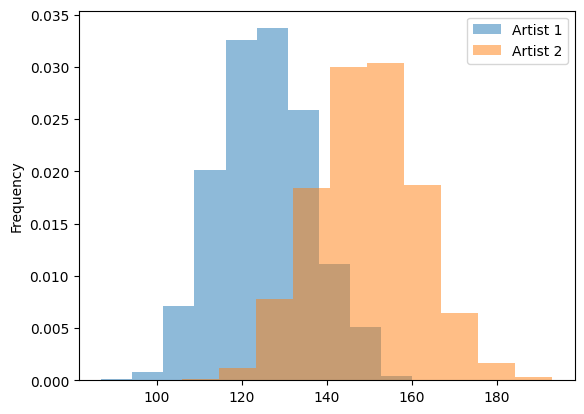

In [61]:
num_replicates = 1000

df = pd.DataFrame({
    "artist" : ['Artist 1'] * num_replicates + ['Artist 2']*num_replicates,
    "length" : np.concatenate((np.random.poisson(125,num_replicates),np.random.poisson(150,num_replicates)))
})

df.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting. 

Q: What does the regular expression `'\s+'` match on? 

A: One or more white space characters. This could be helpful if there are more instances of white space rather than just individual spaces, which is what the split() function does. Split() without any character added splits on individual white spaces, if we used regex it will make sure it splits on any whitespace combinations not just individual spaces


In [62]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyric) : 
    """strip and split on whitespace"""
    return([item.lower() for item in collapse_whitespace.split(lyric)])

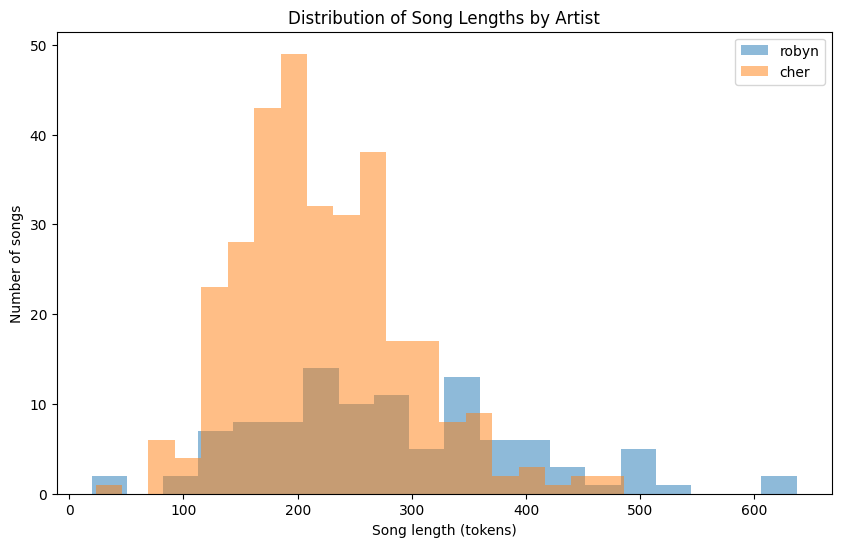

In [64]:
# Your lyric length comparison chart here. 

import matplotlib.pyplot as plt

song_lengths = {}

for artist, songs in lyrics_data.items():
    lengths = []
    for song_name, content in songs.items():
        tokens = tokenize_lyrics(content)
        lengths.append(len(tokens))
    song_lengths[artist] = lengths

plt.figure(figsize=(10, 6))

for artist, lengths in song_lengths.items():
    plt.hist(lengths, bins=20, alpha=0.5, label=artist)

plt.xlabel("Song length (tokens)")
plt.ylabel("Number of songs")
plt.title("Distribution of Song Lengths by Artist")
plt.legend()
plt.show()
